In [23]:
import pandas as pd

# Step 1: Load the dataset
file_path = r'C:\Users\satyarth\Downloads\set_1_converted.csv'  # your local path
df = pd.read_csv(file_path)

# Step 2: Ensure Material is string type
df['Material'] = df['Material'].astype(str)

# Step 3: Filter for Material F360006CP
material_F360006CP = df[df['Material'].str.strip() == 'F360006CP']

# Step 4: Reshape to Time Series (Month → Demand)
# Drop unnecessary columns
drop_cols = ['Material', 'Description', 'Range', 'Subcat']
material_F360006CP_ts = material_F360006CP.drop(columns=drop_cols)

# Step 5: Transpose (flip rows and columns)
material_F360006CP_ts = material_F360006CP_ts.transpose()

# Step 6: Clean the index (remove "Actual" and extra spaces)
material_F360006CP_ts.index = material_F360006CP_ts.index.str.replace('Actual', '', regex=False)
material_F360006CP_ts.index = material_F360006CP_ts.index.str.strip()

# Step 7: Reset index and rename columns
material_F360006CP_ts = material_F360006CP_ts.reset_index()
material_F360006CP_ts.columns = ['Month', 'Demand']

# Step 8: Convert 'Month' into datetime and set it to Month-End
material_F360006CP_ts['Month'] = pd.to_datetime(material_F360006CP_ts['Month'], format='%b %y')
material_F360006CP_ts['Month'] = material_F360006CP_ts['Month'] + pd.offsets.MonthEnd(0)

# Step 9: Final time series ready


# Step 9: Final time series ready
print(material_F360006CP_ts)

# (Optional) Set Month as index if needed
# material_F360006CP_ts = material_F360006CP_ts.set_index('Month')


        Month  Demand
0  2021-04-30    2903
1  2021-05-31    1112
2  2021-06-30    4377
3  2021-07-31    4331
4  2021-08-31    6478
5  2021-09-30    3779
6  2021-10-31    5398
7  2021-11-30    6659
8  2021-12-31    5081
9  2022-01-31    5605
10 2022-02-28    3672
11 2022-03-31    4242
12 2022-04-30    8071
13 2022-05-31    4937
14 2022-06-30    2740
15 2022-07-31    4568
16 2022-08-31    4237
17 2022-09-30    4311
18 2022-10-31    5901
19 2022-11-30    5346
20 2022-12-31    3528
21 2023-01-31    3615
22 2023-02-28    4857
23 2023-03-31    6289
24 2023-04-30    3893
25 2023-05-31    2928
26 2023-06-30    4935
27 2023-07-31    2156
28 2023-08-31    3554
29 2023-09-30    4617
30 2023-10-31    3008
31 2023-11-30    3221



📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   32 non-null     datetime64[ns]
 1   Demand  32 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 644.0 bytes
None

📊 Summary Statistics:
count      32.000000
mean     4385.906250
std      1426.083682
min      1112.000000
25%      3547.500000
50%      4321.000000
75%      5147.250000
max      8071.000000
Name: Demand, dtype: float64

🕵️ Missing Values:
Month     0
Demand    0
dtype: int64


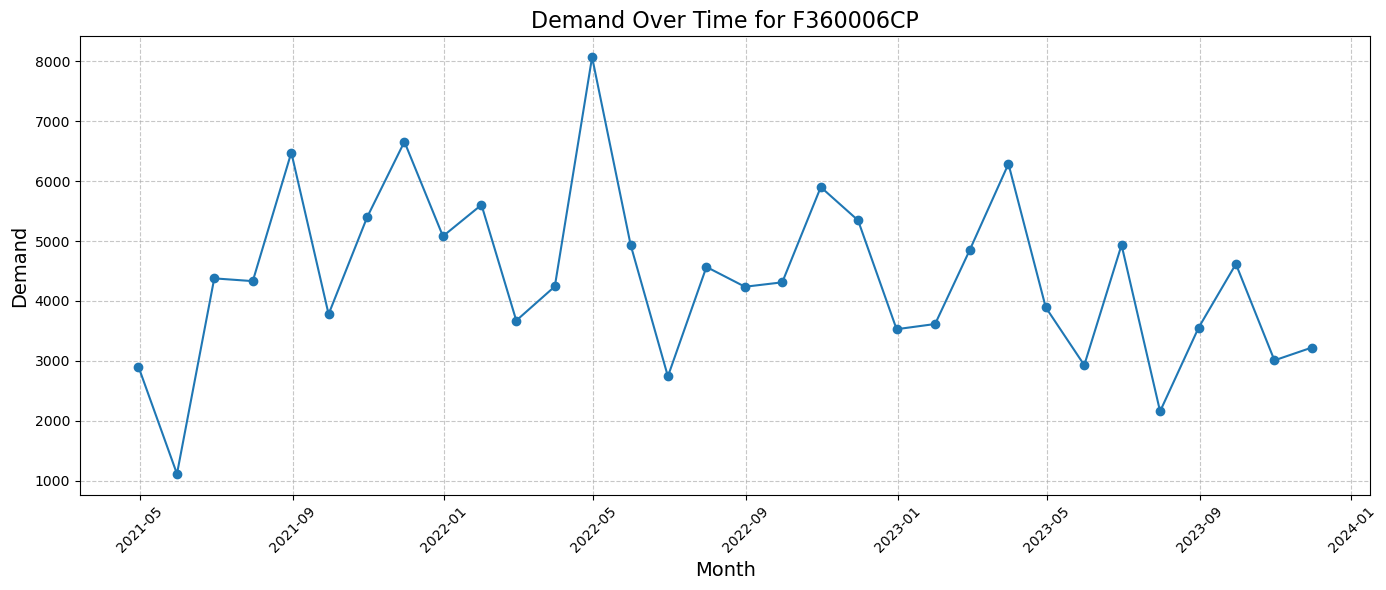

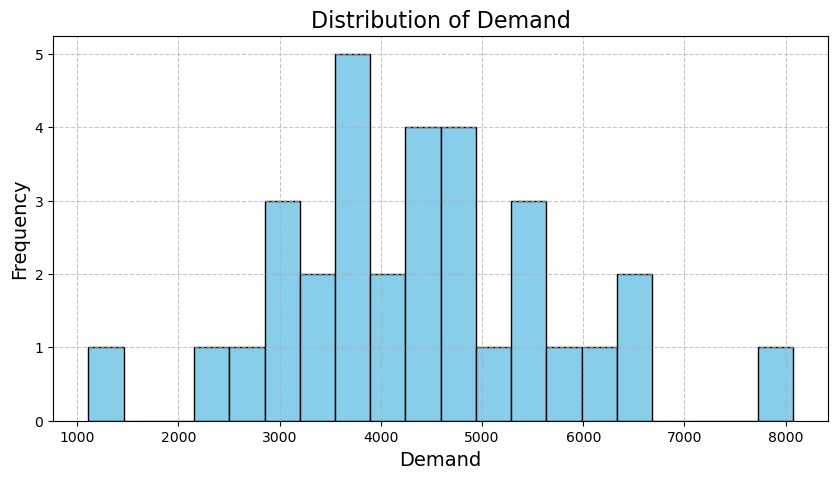


📈 Skewness of Demand: 0.25

🚨 Detected Outliers:
        Month  Demand
1  2021-05-31    1112
12 2022-04-30    8071


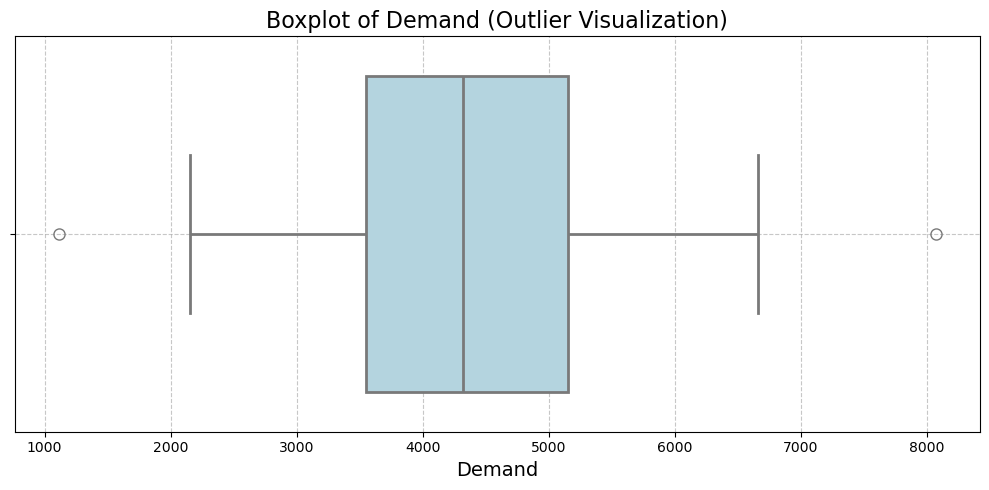

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import skew
import pandas as pd

# Step 1: Basic Info
print("\n📋 Basic Info:")
print(material_F360006CP_ts.info())

# Step 2: Summary Statistics
print("\n📊 Summary Statistics:")
print(material_F360006CP_ts['Demand'].describe())

# Step 3: Check for missing values
print("\n🕵️ Missing Values:")
print(material_F360006CP_ts.isnull().sum())

# Step 4: Plot the time series
plt.figure(figsize=(14,6))
plt.plot(material_F360006CP_ts['Month'], material_F360006CP_ts['Demand'], marker='o', linestyle='-')
plt.title('Demand Over Time for F360006CP', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: Plot Histogram
plt.figure(figsize=(10,5))
plt.hist(material_F360006CP_ts['Demand'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Demand', fontsize=16)
plt.xlabel('Demand', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 6: Check skewness
demand_skewness = skew(material_F360006CP_ts['Demand'].dropna())
print(f"\n📈 Skewness of Demand: {demand_skewness:.2f}")

# Step 7: Detect Outliers using IQR method
Q1 = material_F360006CP_ts['Demand'].quantile(0.25)
Q3 = material_F360006CP_ts['Demand'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = material_F360006CP_ts[
    (material_F360006CP_ts['Demand'] < lower_bound) | 
    (material_F360006CP_ts['Demand'] > upper_bound)
]

print("\n🚨 Detected Outliers:")
print(outliers)

import seaborn as sns

# Step 9: Boxplot to show Outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=material_F360006CP_ts['Demand'], color='lightblue', fliersize=8, linewidth=2)
plt.title('Boxplot of Demand (Outlier Visualization)', fontsize=16)
plt.xlabel('Demand', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




<Figure size 1400x1000 with 0 Axes>

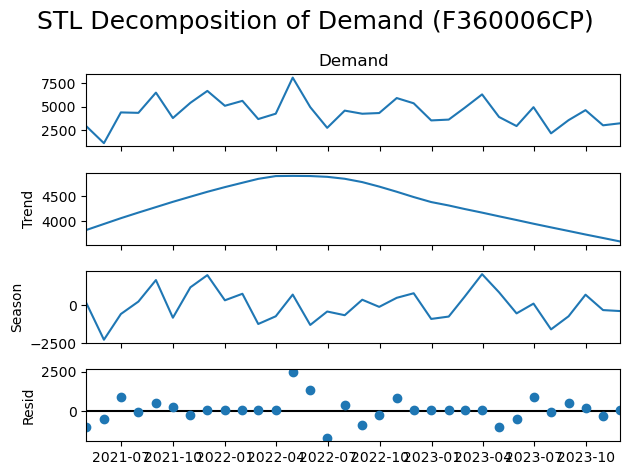

In [25]:
from statsmodels.tsa.seasonal import STL

# Step 1: Set Month as index (if not already)
material_F360006CP_ts_stl = material_F360006CP_ts.set_index('Month')

# Step 2: Perform STL Decomposition
stl = STL(material_F360006CP_ts_stl['Demand'], period=12)  # assuming monthly data with yearly seasonality
result = stl.fit()

# Step 3: Plot the decomposition
plt.figure(figsize=(14,10))
result.plot()
plt.suptitle('STL Decomposition of Demand (F360006CP)', fontsize=18)
plt.tight_layout()
plt.show()


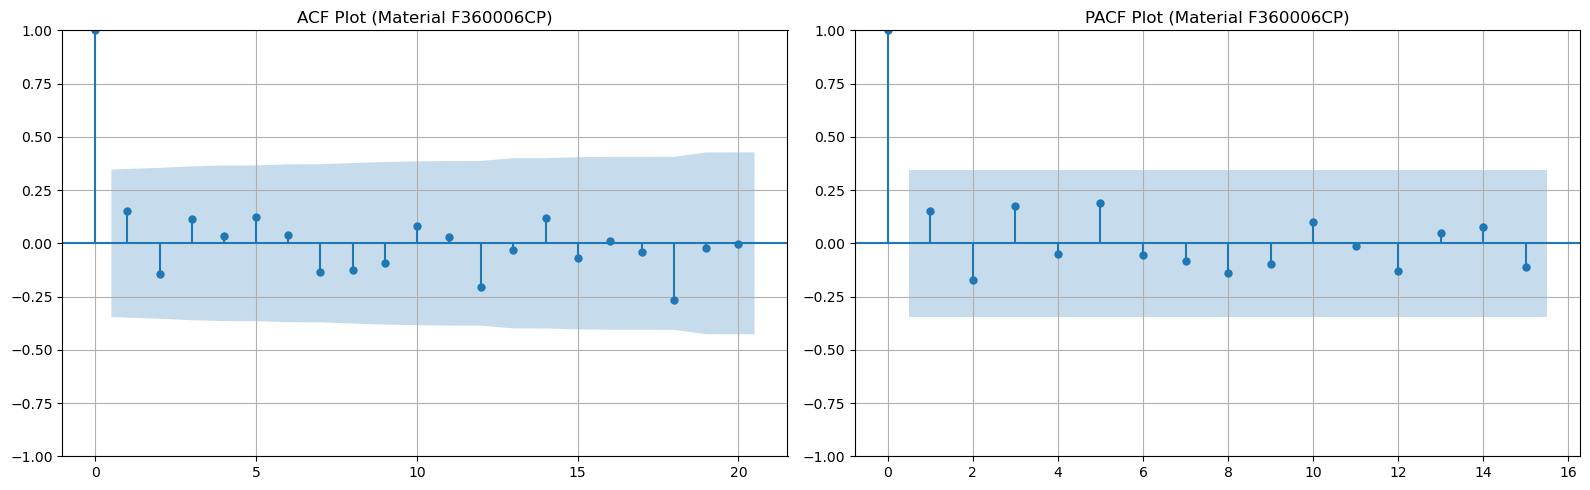

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Only take Demand column for plotting
demand_series = material_F360006CP_ts['Demand']  # 👈 Now using F360006CP

# ACF and PACF Plots for original series
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
plot_acf(demand_series, lags=20, ax=axes[0], title='ACF Plot (Material F360006CP)')
axes[0].grid(True)

# PACF plot
plot_pacf(demand_series, lags=15, ax=axes[1], method='ywm', title='PACF Plot (Material F360006CP)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
from statsmodels.tsa.stattools import adfuller

# Step 10: Run ADF test
result = adfuller(material_F360006CP_ts['Demand'].dropna())  # Drop NaNs just in case

# Step 11: Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -0.21170125799926953
p-value: 0.937112409976026
Critical Values:
   1%: -3.7238633119999998
   5%: -2.98648896
   10%: -2.6328004


In [28]:
# Step 13: Create the first-order differenced series
material_F360006CP_ts['Demand_diff'] = material_F360006CP_ts['Demand'].diff()

# Step 14: Run ADF test on differenced series
result_diff = adfuller(material_F360006CP_ts['Demand_diff'].dropna())  # Drop the first NaN

# Step 14: Print the results
print('ADF Statistic (1st Order Difference):', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')


ADF Statistic (1st Order Difference): -4.0464302094650835
p-value: 0.0011859814223586934
Critical Values:
   1%: -3.7238633119999998
   5%: -2.98648896
   10%: -2.6328004


In [29]:
# Step 15: Split into Train and Test

# Sort data (just to be sure)
material_F360006CP_ts = material_F360006CP_ts.sort_values('Month')

# Train = all months except last 4
train = material_F360006CP_ts.iloc[:-4]

# Test = last 4 months
test = material_F360006CP_ts.iloc[-4:]

# Display sizes
print(f"Train size: {len(train)} months")
print(f"Test size: {len(test)} months")



Train size: 28 months
Test size: 4 months


In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Step 1: Set p, d, q
# (Based on ACF/PACF you saw earlier, assume starting values (p=1, d=1, q=1))
order = (1, 1, 1)

# Step 2: Train ARIMA model on Train Set
model = ARIMA(train['Demand'], order=order)
model_fit = model.fit()

# Step 3: Forecast on Test Set (next 4 months)
forecast_test = model_fit.forecast(steps=len(test))

# Step 4: Calculate MAPE on Test Set
mape_arima = mean_absolute_percentage_error(test['Demand'], forecast_test) * 100
print(f" MAPE on Test Set (ARIMA): {mape_arima:.2f}%")

# Step 5: Retrain ARIMA on full data for future forecast
final_model = ARIMA(material_F360006CP_ts['Demand'], order=order)
final_model_fit = final_model.fit()

# Step 6: Forecast next 3 months (Dec 2023 - Feb 2024)
forecast_index = pd.date_range(start='2023-12-01', periods=3, freq='MS')
forecast_future = final_model_fit.forecast(steps=3)
forecast_future = pd.Series(forecast_future.values, index=forecast_index)

# Step 7: Display Forecast
print("\n Forecast for next 3 months (Dec 2023 - Feb 2024):")
print(forecast_future.round(2))

 MAPE on Test Set (ARIMA): 13.93%

 Forecast for next 3 months (Dec 2023 - Feb 2024):
2023-12-01    3518.66
2024-01-01    3532.55
2024-02-01    3533.20
Freq: MS, dtype: float64


In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Set SARIMA order
# (p,d,q) x (P,D,Q,s)
# Assume: (1,1,1) x (1,1,1,12)  — yearly seasonality (s=12 for months)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Step 2: Train SARIMA model on Train Set
sarima_model = SARIMAX(train['Demand'], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Forecast on Test Set
forecast_sarima_test = sarima_model_fit.forecast(steps=len(test))

# Step 4: Calculate MAPE on Test Set
mape_sarima = mean_absolute_percentage_error(test['Demand'], forecast_sarima_test) * 100
print(f" MAPE on Test Set (SARIMA): {mape_sarima:.2f}%")

# Step 5: Retrain SARIMA on full data
sarima_final_model = SARIMAX(material_F360006CP_ts['Demand'], order=order, seasonal_order=seasonal_order)
sarima_final_fit = sarima_final_model.fit(disp=False)

# Step 6: Forecast next 3 months (Dec 2023 - Feb 2024)
forecast_sarima_future = sarima_final_fit.forecast(steps=3)
forecast_sarima_future = pd.Series(forecast_sarima_future.values, index=forecast_index)

# Step 7: Display Forecast
print("\n Forecast for next 3 months (SARIMA Model):")
print(forecast_sarima_future.round(2))

c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 MAPE on Test Set (SARIMA): 38.63%

 Forecast for next 3 months (SARIMA Model):
2023-12-01    2728.38
2024-01-01    3140.79
2024-02-01    1794.39
Freq: MS, dtype: float64


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Prepare data
train_prophet = train.reset_index().rename(columns={'Month': 'ds', 'Demand': 'y'})
test_prophet = test.reset_index().rename(columns={'Month': 'ds', 'Demand': 'y'})

# Step 2: Train Prophet model
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model_prophet.fit(train_prophet)

# Step 3: Predict on test set
future_test = test_prophet[['ds']]  # Prophet needs a dataframe with 'ds'
forecast_test = model_prophet.predict(future_test)

# Step 4: Calculate MAPE
mape_prophet = mean_absolute_percentage_error(test_prophet['y'], forecast_test['yhat']) * 100
print(f" MAPE on Test Set (Prophet): {mape_prophet:.2f}%")

# Step 5: Retrain on full data and Forecast future 3 months
full_data_prophet = material_F360006CP_ts.reset_index().rename(columns={'Month': 'ds', 'Demand': 'y'})
final_model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
final_model_prophet.fit(full_data_prophet)

# Future 3 months
future_dates = final_model_prophet.make_future_dataframe(periods=3, freq='MS')
forecast_future = final_model_prophet.predict(future_dates)

# Extract only the forecast part
forecast_next3 = forecast_future.set_index('ds').loc['2023-12-01':'2024-02-01', 'yhat']

print("\n Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3.round(2))

16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing


 MAPE on Test Set (Prophet): 79.79%


16:24:06 - cmdstanpy - INFO - Chain [1] done processing



 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
ds
2023-12-01    6459.38
2024-01-01    1563.97
2024-02-01    6338.39
Name: yhat, dtype: float64


In [41]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Fit MA model (q=1, d=1 because already differenced earlier)
model_ma = ARIMA(train['Demand'], order=(0,1,1))
model_ma_fit = model_ma.fit()

# Step 2: Predict for test period
forecast_test_ma = model_ma_fit.forecast(steps=len(test))

# Step 3: Calculate MAPE
mape_ma = mean_absolute_percentage_error(test['Demand'], forecast_test_ma) * 100
print(f" MAPE on Test Set (MA Model): {mape_ma:.2f}%")

# Step 4: Retrain on full data
final_model_ma = ARIMA(material_F360006CP_ts['Demand'], order=(0,1,1))
final_model_ma_fit = final_model_ma.fit()

# Step 5: Forecast next 3 months
forecast_next3_ma = final_model_ma_fit.forecast(steps=3)
forecast_next3_ma.index = pd.date_range(start='2023-12-01', periods=3, freq='MS')

print("\n Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_ma.round(2))

 MAPE on Test Set (MA Model): 13.73%

 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01    3502.56
2024-01-01    3502.56
2024-02-01    3502.56
Freq: MS, Name: predicted_mean, dtype: float64


c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Fit SARIMAX model
# Let's assume non-seasonal order (p,d,q) = (1,1,1)
# and seasonal order (P,D,Q,s) = (1,1,1,12) because monthly seasonality
model_sarimax = SARIMAX(train['Demand'], 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit()

# Step 2: Predict for test period
forecast_test_sarimax = model_sarimax_fit.forecast(steps=len(test))

# Step 3: Calculate MAPE
mape_sarimax = mean_absolute_percentage_error(test['Demand'], forecast_test_sarimax) * 100
print(f" MAPE on Test Set (SARIMAX): {mape_sarimax:.2f}%")

# Step 4: Retrain on full data
final_model_sarimax = SARIMAX(material_F360006CP_ts['Demand'],
                              order=(1,1,1),
                              seasonal_order=(1,1,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
final_model_sarimax_fit = final_model_sarimax.fit()

# Step 5: Forecast next 3 months
forecast_next3_sarimax = final_model_sarimax_fit.forecast(steps=3)
forecast_next3_sarimax.index = pd.date_range(start='2023-12-01', periods=3, freq='MS')

print("\n Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_sarimax.round(2))

c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satyarth\anaconda3\envs\my_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 MAPE on Test Set (SARIMAX): 145.80%

 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01    2473.07
2024-01-01    2120.20
2024-02-01    3232.15
Freq: MS, Name: predicted_mean, dtype: float64


In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Fit ARIMAX model (without exog, same as ARIMA)
model_arimax = SARIMAX(train['Demand'],
                       order=(1,1,1),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
model_arimax_fit = model_arimax.fit()

# Step 2: Predict for test period
forecast_test_arimax = model_arimax_fit.forecast(steps=len(test))

# Step 3: Calculate MAPE
mape_arimax = mean_absolute_percentage_error(test['Demand'], forecast_test_arimax) * 100
print(f" MAPE on Test Set (ARIMAX): {mape_arimax:.2f}%")

# Step 4: Retrain on full data
final_model_arimax = SARIMAX(material_F360006CP_ts['Demand'],
                             order=(1,1,1),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
final_model_arimax_fit = final_model_arimax.fit()

# Step 5: Forecast next 3 months
forecast_next3_arimax = final_model_arimax_fit.forecast(steps=3)
forecast_next3_arimax.index = pd.date_range(start='2023-12-01', periods=3, freq='MS')

print("\n Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_arimax.round(2))


 MAPE on Test Set (ARIMAX): 25.25%

 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01    3978.96
2024-01-01    4178.37
2024-02-01    4230.84
Freq: MS, Name: predicted_mean, dtype: float64


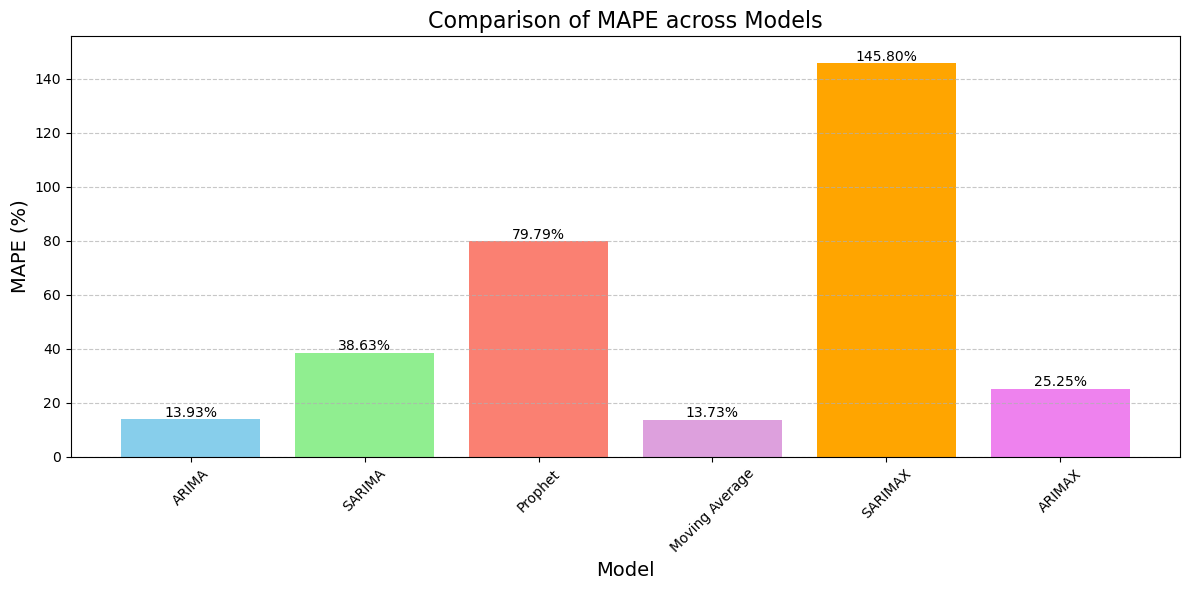

In [36]:
import matplotlib.pyplot as plt

# Step 1: Prepare data
models = ['ARIMA', 'SARIMA', 'Prophet', 'Moving Average', 'SARIMAX', 'ARIMAX']
mape_values = [mape_arima, mape_sarima, mape_prophet, mape_ma, mape_sarimax, mape_arimax]

# Step 2: Plot
plt.figure(figsize=(12,6))
bars = plt.bar(models, mape_values, color=['skyblue', 'lightgreen', 'salmon', 'plum', 'orange', 'violet'])

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', fontsize=10)

# Styling
plt.title('Comparison of MAPE across Models', fontsize=16)
plt.ylabel('MAPE (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(mape_values) + 10)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [37]:
# Find the model with the lowest MAPE
min_mape = min(mape_values)
best_model_index = mape_values.index(min_mape)
best_model = models[best_model_index]

print(f"✅ The model with the lowest MAPE is: **{best_model}** with a MAPE of {min_mape:.2f}%")


✅ The model with the lowest MAPE is: **Moving Average** with a MAPE of 13.73%


C:\Users\satyarth\AppData\Local\Temp\ipykernel_23844\2656123623.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Month': pd.date_range(start='2021-04-30', periods=32, freq='M'),
C:\Users\satyarth\AppData\Local\Temp\ipykernel_23844\2656123623.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satyarth\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


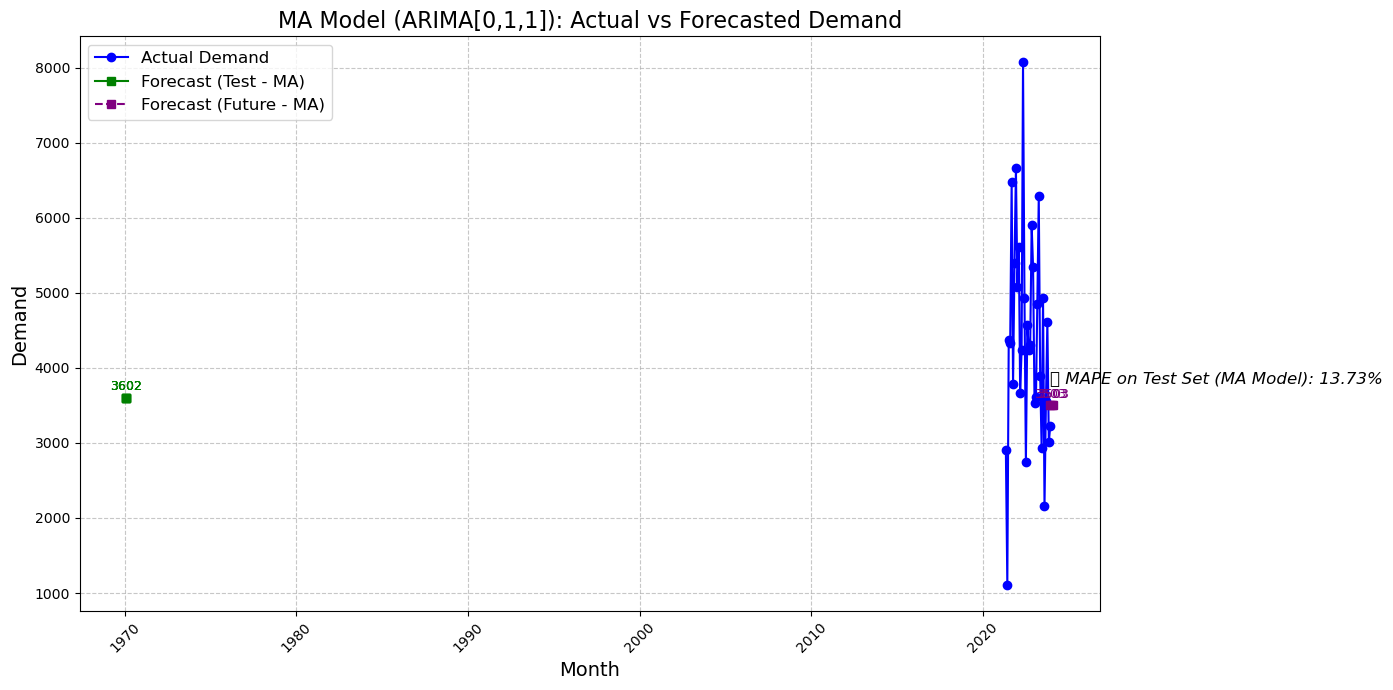


📈 Forecast for Next 3 Months (Dec 2023 - Feb 2024):
2023-12-01    3502.56
2024-01-01    3502.56
2024-02-01    3502.56
Freq: MS, Name: predicted_mean, dtype: float64


In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare full time series
data = {
    'Month': pd.date_range(start='2021-04-30', periods=32, freq='M'),
    'Demand': [
        2903, 1112, 4377, 4331, 6478, 3779, 5398, 6659, 5081, 5605, 3672, 4242,
        8071, 4937, 2740, 4568, 4237, 4311, 5901, 5346, 3528, 3615, 4857, 6289,
        3893, 2928, 4935, 2156, 3554, 4617, 3008, 3221
    ]
}
material_F360006CP_ts = pd.DataFrame(data)
material_F360006CP_ts.set_index('Month', inplace=True)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(material_F360006CP_ts.index, material_F360006CP_ts['Demand'], label='Actual Demand', color='blue', marker='o')

# Forecast on test set (assume forecast_test_ma already has index aligned to Oct–Nov 2023)
plt.plot(forecast_test_ma.index, forecast_test_ma.values, label='Forecast (Test - MA)', color='green', linestyle='-', marker='s')

# Forecast next 3 months (already has datetime index)
plt.plot(forecast_next3_ma.index, forecast_next3_ma.values, label='Forecast (Future - MA)', color='purple', linestyle='--', marker='s')

# Annotate forecasted test values
for x, y in zip(forecast_test_ma.index, forecast_test_ma.values):
    plt.text(x, y + 100, f'{y:.0f}', ha='center', fontsize=9, color='green')

# Annotate future forecast values
for x, y in zip(forecast_next3_ma.index, forecast_next3_ma.values):
    plt.text(x, y + 100, f'{y:.0f}', ha='center', fontsize=9, color='purple')

# Annotate MAPE
plt.text(forecast_next3_ma.index[0], forecast_next3_ma.values[0] + 300,
         f"✅ MAPE on Test Set (MA Model): {mape_ma:.2f}%", 
         ha='left', fontsize=12, color='black', style='italic')

# Styling
plt.title('MA Model (ARIMA[0,1,1]): Actual vs Forecasted Demand', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print future forecast
print("\n📈 Forecast for Next 3 Months (Dec 2023 - Feb 2024):")
print(forecast_next3_ma.round(2))




